# Import Library

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import itertools
from sklearnex import patch_sklearn
from sklearn.model_selection import KFold, LeaveOneOut,cross_validate, cross_val_score
import matplotlib.pyplot as plt
from sklearn import metrics

np.random.seed(42)
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Define Functions

## Model Tuning Function

In [2]:
def model_tuning(clf, model_name, cv, X_train_scaled, y_train):
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.neural_network import MLPRegressor
    from sklearn.svm import SVR
    from xgboost import XGBRegressor
    from lightgbm import LGBMRegressor
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.gaussian_process import GaussianProcessRegressor
    from catboost import CatBoostRegressor
    from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


    if model_name == 'svr':
        param = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]}
        grid = GridSearchCV(clf, param, cv=cv, n_jobs=-1)
        grid.fit(X_train_scaled, y_train)
        C = grid.best_params_['C']
        gamma = grid.best_params_['gamma']
        model = SVR(C=C, gamma=gamma, kernel='rbf')

    elif model_name == 'rf':
        param = {'max_features':['sqrt', 'auto'], 'max_depth':[int(x) for x in np.linspace(2, 10, num = 5)], 'min_samples_leaf':[1,3,4],
                 'n_estimators':[5,10,20,100], 'min_samples_split':[2, 6, 10], 'bootstrap':[True, False]}
        grid = GridSearchCV(clf, param, cv=cv, n_jobs=-1)
        grid.fit(X_train_scaled, y_train)
        n_estimators = grid.best_params_['n_estimators']
        min_samples_leaf = grid.best_params_['min_samples_leaf']
        max_features = grid.best_params_['max_features']
        max_depth = grid.best_params_['max_depth']
        min_samples_split = grid.best_params_['min_samples_split']
        bootstrap = grid.best_params_['bootstrap']
        model = RandomForestRegressor(max_features = max_features, max_depth = max_depth, min_samples_leaf=min_samples_leaf,n_estimators=n_estimators, min_samples_split=min_samples_split, bootstrap=bootstrap, random_state=42)

    elif model_name == 'mlp':
        param = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
                 'activation': ['tanh', 'relu'],
                 'solver': ['sgd', 'adam'],
                 'alpha': [0.0001, 0.05],
                 'learning_rate': ['constant','adaptive']}
        grid = GridSearchCV(clf, param, cv=cv, n_jobs=-1)
        grid.fit(X_train_scaled, y_train)
        hidden_layer_sizes = grid.best_params_['hidden_layer_sizes']
        activation = grid.best_params_['activation']
        solver = grid.best_params_['solver']
        alpha = grid.best_params_['alpha']
        learning_rate = grid.best_params_['learning_rate']
        model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, alpha=alpha, learning_rate=learning_rate,random_state=42)

    elif model_name == 'dt':
        param = {"max_depth" : [1,3,5,7,9,11,12],
                 "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
                 "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                 "max_features":["auto","log2","sqrt",None],
                 "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90]}
        grid = GridSearchCV(clf, param, cv=cv, n_jobs=-1)
        grid.fit(X_train_scaled, y_train)
        min_samples_leaf = grid.best_params_['min_samples_leaf']
        max_features = grid.best_params_['max_features']
        max_depth = grid.best_params_['max_depth']
        min_weight_fraction_leaf = grid.best_params_['min_weight_fraction_leaf']
        max_leaf_nodes = grid.best_params_['max_leaf_nodes']
        model = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf, max_features=max_features, max_depth=max_depth, min_weight_fraction_leaf=min_weight_fraction_leaf, max_leaf_nodes=max_leaf_nodes, random_state=42)

    elif model_name == 'gb':
        param = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 10],
            'learning_rate': [0.01, 0.1, 1]
        }
        grid = GridSearchCV(clf, param, cv=cv, n_jobs=-1)
        grid.fit(X_train_scaled, y_train)
        n_estimators = grid.best_params_['n_estimators']
        max_depth = grid.best_params_['max_depth']
        learning_rate = grid.best_params_['learning_rate']
        model = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=42)

    elif model_name == 'xgb':
        param = {'min_child_weight': [1, 5, 15, 20, 100, 150, 200],
                 'learning_rate': np.logspace(-3, 0, 100),
                 'max_depth': np.arange(3, 10, 1),
                 'gamma': [1,0.1,0.01,0.001,0.0001],
                 'lambda': [1,0.1,0.01,0.001,0.0001],
                 'alpha': [1,0.1,0.01,0.001,0.0001],
                 'subsample': np.linspace(0.5, 1, 10),
                 'colsample_bytree': np.linspace(0.5, 1, 10)}
        grid = RandomizedSearchCV(clf, param, cv=cv, n_jobs=-1, random_state=42)
        grid.fit(X_train_scaled, y_train)
        min_child_weight = grid.best_params_['min_child_weight']
        gamma = grid.best_params_['gamma']
        reg_lambda = grid.best_params_['lambda']
        alpha = grid.best_params_['alpha']
        learning_rate = grid.best_params_['learning_rate']
        max_depth = grid.best_params_['max_depth']
        subsample = grid.best_params_['subsample']
        colsample_bytree = grid.best_params_['colsample_bytree']
        model = XGBRegressor(min_child_weight=min_child_weight, learning_rate=learning_rate, max_depth=max_depth, subsample=subsample, colsample_bytree=colsample_bytree, gamma=gamma, reg_lambda=reg_lambda, alpha=alpha, random_state=42)

    elif model_name == 'lgbm':
        param = {'n_estimators': np.arange(100, 1000, 100),
                 'learning_rate': np.logspace(-3, 0, 100),
                 'max_depth': np.arange(3, 10, 1),
                 'subsample': np.linspace(0.5, 1, 10),
                 'colsample_bytree': np.linspace(0.5, 1, 10)}
        grid = RandomizedSearchCV(clf, param, cv=cv, n_jobs=-1, random_state=42)
        grid.fit(X_train_scaled, y_train)
        n_estimators = grid.best_params_['n_estimators']
        learning_rate = grid.best_params_['learning_rate']
        max_depth = grid.best_params_['max_depth']
        subsample = grid.best_params_['subsample']
        colsample_bytree = grid.best_params_['colsample_bytree']
        model = LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, subsample=subsample, colsample_bytree=colsample_bytree, random_state=42)

    elif model_name == 'knn':
        param = {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
        grid = GridSearchCV(clf, param, cv=cv, n_jobs=-1)
        grid.fit(X_train_scaled, y_train)
        n_neighbors = grid.best_params_['n_neighbors']
        weights = grid.best_params_['weights']
        p = grid.best_params_['p']
        model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, p=p)

    elif model_name == 'gp':
        param = {
            'alpha': [1e-10, 1e-5, 1e-3],
            'n_restarts_optimizer': [0, 1, 5]
        }
        grid = GridSearchCV(clf, param, cv=cv, n_jobs=-1)
        grid.fit(X_train_scaled, y_train)
        alpha = grid.best_params_['alpha']
        n_restarts_optimizer = grid.best_params_['n_restarts_optimizer']
        model = GaussianProcessRegressor(alpha=alpha, n_restarts_optimizer=n_restarts_optimizer, random_state=42)

    elif model_name == 'cb':
        param = {'iterations': [100, 500, 1000],
                 'learning_rate': [0.01, 0.1, 1],
                 'depth': [4, 6, 8]}
        grid = GridSearchCV(clf, param, cv=cv, n_jobs=-1)
        grid.fit(X_train_scaled, y_train)
        iterations = grid.best_params_['iterations']
        learning_rate = grid.best_params_['learning_rate']
        depth = grid.best_params_['depth']
        model = CatBoostRegressor(iterations=iterations, learning_rate=learning_rate, depth=depth, random_state=42)

    return model

## Model Selection Function

In [3]:
def evaluate_model(X_train, y_train):
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.neural_network import MLPRegressor
    from sklearn.svm import SVR
    from xgboost import XGBRegressor
    from lightgbm import LGBMRegressor
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.gaussian_process import GaussianProcessRegressor
    from catboost import CatBoostRegressor
    from sklearn.model_selection import LeaveOneOut, cross_val_score
    from scipy.stats import kstest

    mlp = MLPRegressor(random_state=42)
    svr = SVR()
    dt = DecisionTreeRegressor(random_state=42)
    gb = GradientBoostingRegressor(random_state=42)
    xgb = XGBRegressor(random_state=42)
    lgbm = LGBMRegressor(random_state=42)
    knn = KNeighborsRegressor()
    gp = GaussianProcessRegressor(random_state=42)
    cb = CatBoostRegressor(random_state=42)
    rf = RandomForestRegressor(random_state=42)

    list_model = [mlp, svr, dt, gb, xgb, lgbm, knn, gp, cb, rf]
    model_name = ['mlp', 'svr', 'dt', 'gb', 'xgb', 'lgbm', 'knn', 'gp', 'cb', 'rf']
    model_rmse = []
    model_mae = []
    model_mape = []
    neg_stat_list = []

    for i in list_model:
        i.fit(X_train, y_train)

        rmse = np.mean(cross_val_score(i, X_train, y_train, cv=LeaveOneOut(), scoring='neg_root_mean_squared_error', n_jobs=-1))
        mape = np.mean(cross_val_score(i, X_train, y_train, cv=LeaveOneOut(), scoring='neg_mean_absolute_percentage_error', n_jobs=-1))
        mae = np.mean(cross_val_score(i, X_train, y_train, cv=LeaveOneOut(), scoring='neg_mean_absolute_error', n_jobs=-1))
        stat, p = kstest(y_train-i.predict(X_train), 'norm')
        neg_stat = -1*stat

        model_rmse.append(rmse)
        model_mae.append(mae)
        model_mape.append(mape)
        neg_stat_list.append(neg_stat)

    df_model = pd.DataFrame(list(zip(list_model, model_name, model_rmse, model_mape, model_mae, neg_stat_list)), columns=['model', 'model_name', 'RMSE', 'MAPE', 'MAE', 'neg_stat'])
    df_model_sorted = df_model.sort_values(by=['RMSE', 'neg_stat', 'MAPE', 'MAE'], ascending=False)

    return list(df_model_sorted['model'])[0], list(df_model_sorted['model_name'])[0], df_model_sorted

# Data Load

In [4]:
df = pd.read_excel("AHMVAR.xlsx", sheet_name='AHMResult')

In [5]:
df_water = df.drop(['GasTotal (MSCF)'], axis=1)
df_gas = df.drop(['WaterTotal (STB)'], axis=1)

## Define Features and Target

In [6]:
X_water, y_water = df_water.drop(['WaterTotal (STB)'], axis=1), df_water['WaterTotal (STB)']
X_gas, y_gas = df_gas.drop(['GasTotal (MSCF)'], axis=1), df_gas['GasTotal (MSCF)']

## Categorical Feature Encoding

In [7]:
list_rotation = []

for i in range(0, 180):
    list_rotation.append(f'FracturePath {i}°')

In [8]:
list_rotation

['FracturePath 0°',
 'FracturePath 1°',
 'FracturePath 2°',
 'FracturePath 3°',
 'FracturePath 4°',
 'FracturePath 5°',
 'FracturePath 6°',
 'FracturePath 7°',
 'FracturePath 8°',
 'FracturePath 9°',
 'FracturePath 10°',
 'FracturePath 11°',
 'FracturePath 12°',
 'FracturePath 13°',
 'FracturePath 14°',
 'FracturePath 15°',
 'FracturePath 16°',
 'FracturePath 17°',
 'FracturePath 18°',
 'FracturePath 19°',
 'FracturePath 20°',
 'FracturePath 21°',
 'FracturePath 22°',
 'FracturePath 23°',
 'FracturePath 24°',
 'FracturePath 25°',
 'FracturePath 26°',
 'FracturePath 27°',
 'FracturePath 28°',
 'FracturePath 29°',
 'FracturePath 30°',
 'FracturePath 31°',
 'FracturePath 32°',
 'FracturePath 33°',
 'FracturePath 34°',
 'FracturePath 35°',
 'FracturePath 36°',
 'FracturePath 37°',
 'FracturePath 38°',
 'FracturePath 39°',
 'FracturePath 40°',
 'FracturePath 41°',
 'FracturePath 42°',
 'FracturePath 43°',
 'FracturePath 44°',
 'FracturePath 45°',
 'FracturePath 46°',
 'FracturePath 47°',
 '

In [9]:
feature_lists = [list_rotation, list(X_water['FracType'].unique()), list(X_water['FracStages'].unique()) + [1, 2, 3, 4, 5, 6, 7, 8, 9]]

In [10]:
feature_combinations = pd.DataFrame(list(itertools.product(*feature_lists)), columns=['FracRotation', 'FracType', 'FracStages'])

In [11]:
OHE = OneHotEncoder(sparse=False)

In [12]:
OHE.fit(feature_combinations)

C:\Users\adamz\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(sparse=False, sparse_output=False)

In [13]:
X_water_OHE, X_gas_OHE = OHE.transform(X_water), OHE.transform(X_gas)

# Train-Test Split

In [14]:
from sklearn.model_selection import train_test_split

X_gas_train, X_gas_test, y_gas_train, y_gas_test = train_test_split(X_gas_OHE, y_gas, test_size=0.2, random_state=42)
X_water_train, X_water_test, y_water_train, y_water_test = train_test_split(X_water_OHE, y_water, test_size=0.2, random_state=42)

# Model Development

## Model Selection

In [15]:
model_water, model_name_water, model_water_sorted = evaluate_model(X_water_train, y_water_train)
model_gas, model_name_gas, model_gas_sorted = evaluate_model(X_gas_train, y_gas_train)

C:\Users\adamz\anaconda3\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
C:\Users\adamz\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 46
[LightGBM] [Info] Number of data points in the train set: 308, number of used features: 23
[LightGBM] [Info] Start training from score 1107378.042614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

C:\Users\adamz\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46
[LightGBM] [Info] Number of data points in the train set: 308, number of used features: 23
[LightGBM] [Info] Start training from score 153275277.831169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

## Hyperparameter Tuning

### Water Model Cross Validation

In [16]:
train_score_water = []
test_score_water = []
opt_score_water = np.mean(cross_val_score(model_water, X_water_train, y_water_train, cv=LeaveOneOut(), scoring='neg_root_mean_squared_error', n_jobs=-1))
for i in range(2,21):
    score = cross_validate(model_water, X_water_train, y_water_train, cv=KFold(n_splits=i), scoring='neg_root_mean_squared_error', return_train_score=True, n_jobs=-1)
    test_score_water.append(np.mean(score['test_score']))
    train_score_water.append(np.mean(score['train_score']))

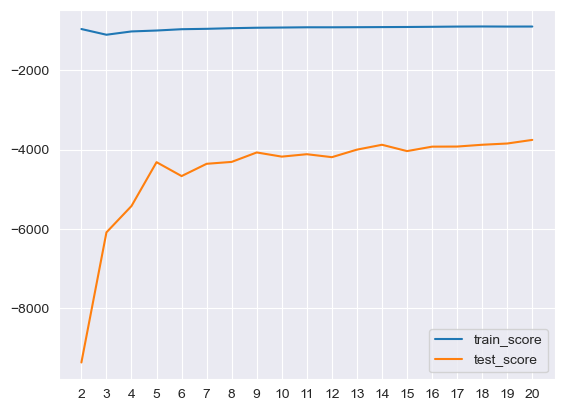

In [17]:
#Cross validation plot to determine if the model is overfitting or underfitting
fig1 = plt.figure('Cross Validation - model')
plt.plot(list(range(2, 21)), train_score_water, label='train_score')
plt.plot(list(range(2, 21)), test_score_water, label='test_score')
plt.xticks(list(range(2, 21)))
plt.legend()
plt.show()

In [18]:
diff_score_opt_water = [abs(i-opt_score_water) for i in test_score_water]
diff_score_train_water = [abs(i-j) for i,j in zip(test_score_water, train_score_water)]
df_cv_water = pd.DataFrame(list(zip(list(range(2, 21)), diff_score_opt_water, diff_score_train_water)))

### Gas Model Cross Validation

In [19]:
train_score_gas = []
test_score_gas = []
opt_score_gas = np.mean(cross_val_score(model_gas, X_gas_train, y_gas_train, cv=LeaveOneOut(), scoring='neg_root_mean_squared_error', n_jobs=-1))
for i in range(2,21):
    score = cross_validate(model_gas, X_gas_train, y_gas_train, cv=KFold(n_splits=i), scoring='neg_root_mean_squared_error', return_train_score=True, n_jobs=-1)
    test_score_gas.append(np.mean(score['test_score']))
    train_score_gas.append(np.mean(score['train_score']))

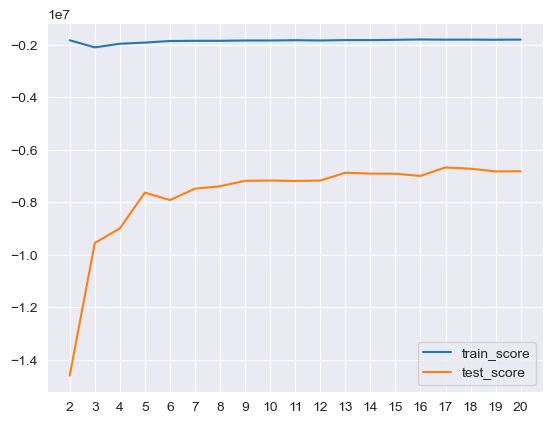

In [20]:
#Cross validation plot to determine if the model is overfitting or underfitting
fig1 = plt.figure('Cross Validation - model')
plt.plot(list(range(2, 21)), train_score_gas, label='train_score')
plt.plot(list(range(2, 21)), test_score_gas, label='test_score')
plt.xticks(list(range(2, 21)))
plt.legend()
plt.show()

In [21]:
diff_score_opt_gas = [abs(i-opt_score_gas) for i in test_score_gas]
diff_score_train_gas = [abs(i-j) for i,j in zip(test_score_gas, train_score_gas)]
df_cv_gas = pd.DataFrame(list(zip(list(range(2, 21)), diff_score_opt_gas, diff_score_train_gas)))

### Water Model Tuning

In [22]:
cv_water = KFold(n_splits=int(df_cv_water.sort_values(by=[2, 1], ascending=True).iloc[0][0]))
model_opt_water = model_tuning(model_water, model_name_water, cv_water, X_water_train, y_water_train)

0:	learn: 48386.0381957	total: 509us	remaining: 509ms
1:	learn: 45934.8430715	total: 1.24ms	remaining: 620ms
2:	learn: 43432.7378715	total: 1.58ms	remaining: 524ms
3:	learn: 40882.9972719	total: 1.9ms	remaining: 474ms
4:	learn: 38925.4609798	total: 2.21ms	remaining: 440ms
5:	learn: 37218.3876601	total: 2.52ms	remaining: 418ms
6:	learn: 35234.0168367	total: 2.83ms	remaining: 402ms
7:	learn: 33562.4595956	total: 3.12ms	remaining: 387ms
8:	learn: 32196.2907191	total: 3.42ms	remaining: 377ms
9:	learn: 30354.5976723	total: 3.73ms	remaining: 369ms
10:	learn: 28888.7368710	total: 4.03ms	remaining: 362ms
11:	learn: 27708.8734444	total: 4.34ms	remaining: 357ms
12:	learn: 26469.0603793	total: 4.63ms	remaining: 351ms
13:	learn: 25425.2834324	total: 4.92ms	remaining: 347ms
14:	learn: 24387.8768226	total: 5.22ms	remaining: 343ms
15:	learn: 23688.7540875	total: 5.52ms	remaining: 340ms
16:	learn: 23057.0339034	total: 5.84ms	remaining: 338ms
17:	learn: 22054.5345986	total: 6.16ms	remaining: 336ms
18:	

In [23]:
model_opt_water.fit(X_water_train, y_water_train)

0:	learn: 48386.0381957	total: 567us	remaining: 567ms
1:	learn: 45934.8430715	total: 1.22ms	remaining: 609ms
2:	learn: 43432.7378715	total: 1.6ms	remaining: 532ms
3:	learn: 40882.9972719	total: 2.01ms	remaining: 500ms
4:	learn: 38925.4609798	total: 2.35ms	remaining: 468ms
5:	learn: 37218.3876601	total: 2.67ms	remaining: 442ms
6:	learn: 35234.0168367	total: 2.97ms	remaining: 422ms
7:	learn: 33562.4595956	total: 3.27ms	remaining: 406ms
8:	learn: 32196.2907191	total: 3.58ms	remaining: 394ms
9:	learn: 30354.5976723	total: 3.89ms	remaining: 385ms
10:	learn: 28888.7368710	total: 4.52ms	remaining: 406ms
11:	learn: 27708.8734444	total: 4.85ms	remaining: 399ms
12:	learn: 26469.0603793	total: 5.19ms	remaining: 394ms
13:	learn: 25425.2834324	total: 5.55ms	remaining: 391ms
14:	learn: 24387.8768226	total: 5.91ms	remaining: 388ms
15:	learn: 23688.7540875	total: 6.31ms	remaining: 388ms
16:	learn: 23057.0339034	total: 6.72ms	remaining: 389ms
17:	learn: 22054.5345986	total: 7.05ms	remaining: 385ms
18:	

### Gas Model Tuning

In [24]:
cv_gas = KFold(n_splits=int(df_cv_gas.sort_values(by=[2, 1], ascending=True).iloc[0][0]))
model_opt_gas = model_tuning(model_gas, model_name_gas, cv_gas, X_gas_train, y_gas_train)

0:	learn: 57027195.7267525	total: 540us	remaining: 540ms
1:	learn: 53995638.1028325	total: 1.31ms	remaining: 653ms
2:	learn: 51157819.6201127	total: 1.78ms	remaining: 591ms
3:	learn: 49415895.1220009	total: 2.1ms	remaining: 523ms
4:	learn: 46995995.8774065	total: 2.55ms	remaining: 507ms
5:	learn: 44884522.3825119	total: 2.99ms	remaining: 496ms
6:	learn: 42750304.7908408	total: 3.42ms	remaining: 486ms
7:	learn: 41251333.7486948	total: 3.85ms	remaining: 478ms
8:	learn: 39452445.8055154	total: 4.33ms	remaining: 476ms
9:	learn: 38061098.5157411	total: 4.8ms	remaining: 475ms
10:	learn: 36568189.2168800	total: 5.26ms	remaining: 473ms
11:	learn: 35243561.5364077	total: 5.76ms	remaining: 474ms
12:	learn: 34010498.0817813	total: 6.21ms	remaining: 472ms
13:	learn: 32664446.9980537	total: 6.64ms	remaining: 468ms
14:	learn: 31796066.8720354	total: 7.12ms	remaining: 467ms
15:	learn: 30776778.4302502	total: 7.61ms	remaining: 468ms
16:	learn: 29804086.3065944	total: 8.06ms	remaining: 466ms
17:	learn:

In [25]:
model_opt_gas.fit(X_gas_train, y_gas_train)

0:	learn: 57027195.7267525	total: 557us	remaining: 557ms
1:	learn: 53995638.1028325	total: 1.37ms	remaining: 682ms
2:	learn: 51157819.6201127	total: 1.87ms	remaining: 622ms
3:	learn: 49415895.1220009	total: 2.23ms	remaining: 556ms
4:	learn: 46995995.8774065	total: 2.68ms	remaining: 534ms
5:	learn: 44884522.3825119	total: 3.2ms	remaining: 530ms
6:	learn: 42750304.7908408	total: 3.74ms	remaining: 530ms
7:	learn: 41251333.7486948	total: 4.33ms	remaining: 538ms
8:	learn: 39452445.8055154	total: 4.92ms	remaining: 542ms
9:	learn: 38061098.5157411	total: 5.44ms	remaining: 539ms
10:	learn: 36568189.2168800	total: 5.93ms	remaining: 533ms
11:	learn: 35243561.5364077	total: 6.41ms	remaining: 528ms
12:	learn: 34010498.0817813	total: 6.94ms	remaining: 527ms
13:	learn: 32664446.9980537	total: 7.46ms	remaining: 525ms
14:	learn: 31796066.8720354	total: 7.95ms	remaining: 522ms
15:	learn: 30776778.4302502	total: 8.46ms	remaining: 520ms
16:	learn: 29804086.3065944	total: 8.93ms	remaining: 516ms
17:	learn

### Water Model Score

In [26]:
print('Mean Absolute Error:', metrics.mean_absolute_error(model_opt_water.predict(X_water_test), y_water_test))
print('Mean Squared Error:', metrics.mean_squared_error(model_opt_water.predict(X_water_test), y_water_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(model_opt_water.predict(X_water_test), y_water_test)))

Mean Absolute Error: 2025.5378087585877
Mean Squared Error: 9141595.156032054
Root Mean Squared Error: 3023.5070954161915


In [72]:
print('Mean Absolute Error:', metrics.mean_absolute_error(model_opt_water.predict(X_water_train), y_water_train))
print('Mean Squared Error:', metrics.mean_squared_error(model_opt_water.predict(X_water_train), y_water_train))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(model_opt_water.predict(X_water_train), y_water_train)))

Mean Absolute Error: 511.3723250014417
Mean Squared Error: 415487.3263770137
Root Mean Squared Error: 644.5830639855609


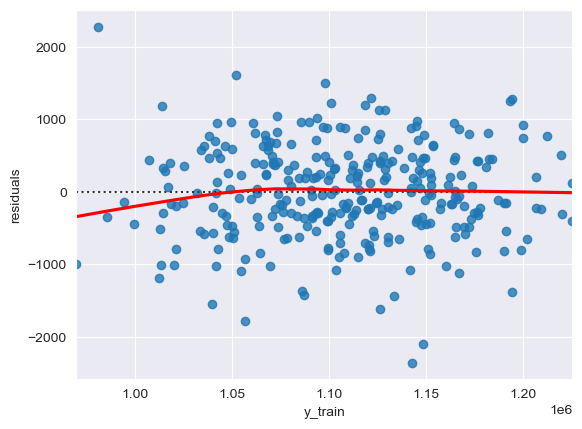

In [74]:
import seaborn as sns

fig1 = plt.figure('Residual Plot - Water_Train')
sns.residplot(x = y_water_train, y=(y_water_train - model_opt_water.predict(X_water_train)), lowess=True, line_kws=dict(color="r")).set(xlabel='y_train', ylabel='residuals')
plt.show()

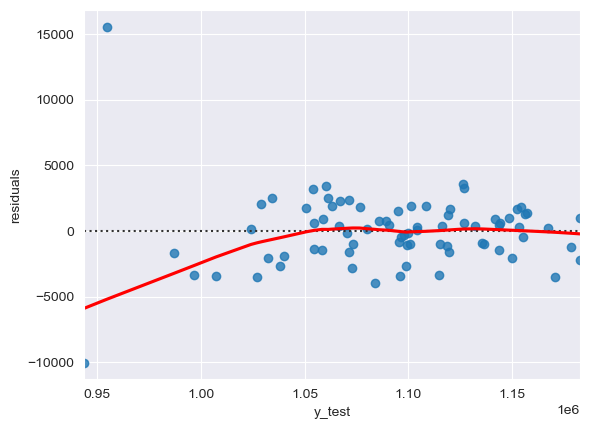

In [75]:
fig2 = plt.figure('Residual Plot - Water_Test')
sns.residplot(x = y_water_test, y=(y_water_test - model_opt_water.predict(X_water_test)), lowess=True, line_kws=dict(color="r")).set(xlabel='y_test', ylabel='residuals')
plt.show()

### Gas Model Score

In [27]:
print('Mean Absolute Error:', metrics.mean_absolute_error(model_opt_gas.predict(X_gas_test), y_gas_test))
print('Mean Squared Error:', metrics.mean_squared_error(model_opt_gas.predict(X_gas_test), y_gas_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(model_opt_gas.predict(X_gas_test), y_gas_test)))

Mean Absolute Error: 4635520.422440018
Mean Squared Error: 41495949525000.055
Root Mean Squared Error: 6441734.977861171


In [73]:
print('Mean Absolute Error:', metrics.mean_absolute_error(model_opt_gas.predict(X_gas_train), y_gas_train))
print('Mean Squared Error:', metrics.mean_squared_error(model_opt_gas.predict(X_gas_train), y_gas_train))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(model_opt_gas.predict(X_gas_train), y_gas_train)))

Mean Absolute Error: 240726.738217866
Mean Squared Error: 80278100486.3953
Root Mean Squared Error: 283333.90281855664


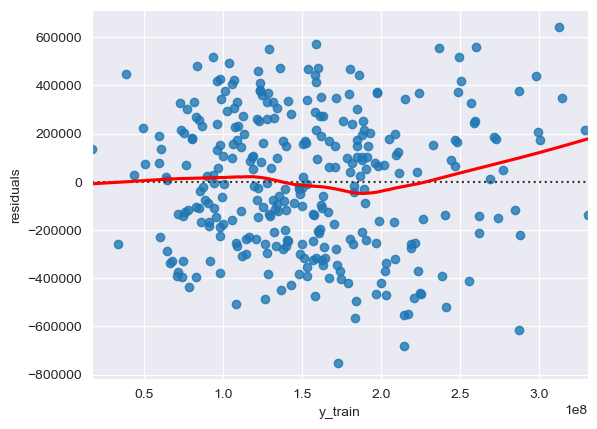

In [76]:
fig3 = plt.figure('Residual Plot - Gas_Train')
sns.residplot(x = y_gas_train, y=(y_gas_train - model_opt_gas.predict(X_gas_train)), lowess=True, line_kws=dict(color="r")).set(xlabel='y_train', ylabel='residuals')
plt.show()

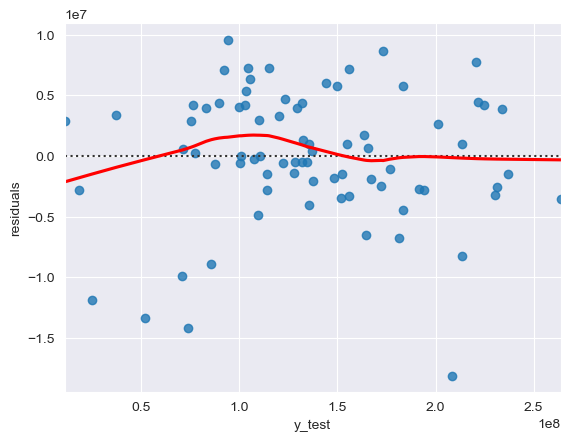

In [77]:
fig4 = plt.figure('Residual Plot - Gas_Test')
sns.residplot(x = y_gas_test, y=(y_gas_test - model_opt_gas.predict(X_gas_test)), lowess=True, line_kws=dict(color="r")).set(xlabel='y_test', ylabel='residuals')
plt.show()

# Optimization Process

In [28]:
OHE.transform(pd.DataFrame([['FracturePath 30°', 'TYPE 1', 10]], columns=['FracRotation', 'FracType', 'FracStages']))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

## Define Optimization Function

In [29]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Integer, Choice

class OilGasProblem(ElementwiseProblem):

    def __init__(self, **kwargs):
        vars = {
            "r": Choice(options=feature_lists[0]),
            "t": Choice(options=feature_lists[1]),
            "s": Integer(bounds=(1, 20)),
        }
        super().__init__(vars=vars, n_obj=2, **kwargs)

    def _evaluate(self, X, out, *args, **kwargs):
        r, t, s = X["r"], X["t"], X["s"]

        v = OHE.transform(pd.DataFrame([[r, t, s]], columns=['FracRotation', 'FracType', 'FracStages']))

        f1 = model_opt_water.predict(v)
        f2 = -1*model_opt_gas.predict(v)

        out["F"] = [f1, f2]

problem = OilGasProblem()

In [79]:
from pymoo.core.mixed import MixedVariableGA, MixedVariableMating, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.algorithms.moo.nsga2 import RankAndCrowding, NSGA2
from pymoo.algorithms.moo.sms import SMSEMOA

algorithm3 = MixedVariableGA(pop_size=50, survival=RankAndCrowding())
algorithm2 = SMSEMOA(mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),sampling=MixedVariableSampling(), eliminate_duplicates=MixedVariableDuplicateElimination())
algorithm1 = NSGA2(mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),sampling=MixedVariableSampling(), eliminate_duplicates=MixedVariableDuplicateElimination())
list_algorithm = [algorithm1, algorithm2, algorithm3]

In [80]:
from pymoo.optimize import minimize

list_minimize = []

for i in list_algorithm:
    res = minimize(problem, i, ('n_gen', 1000), seed=42, verbose=True)
    
    list_minimize.append([res.F, res.X])

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       99 |     77 |             - |             -
     2 |      199 |    100 |  0.0019021633 |             f
     3 |      299 |    100 |  0.1354106875 |         ideal
     4 |      399 |    100 |  0.1690836999 |         ideal
     5 |      499 |    100 |  0.0024118496 |             f
     6 |      599 |    100 |  0.1436495758 |         ideal
     7 |      699 |    100 |  0.0014387146 |             f
     8 |      799 |    100 |  0.0025527033 |             f
     9 |      899 |     86 |  0.0012717832 |             f
    10 |      999 |     55 |  0.0280463251 |         ideal
    11 |     1099 |     72 |  0.2515856031 |         ideal
    12 |     1199 |     85 |  0.0409381429 |         ideal
    13 |     1299 |    100 |  0.0988395692 |         ideal
    14 |     1399 |    100 |  0.0006869308 |             f
    15 |     1499 |    100 |  0.0013560586 |             f
    16 |     1599 |    100 |  0.0015523432 |            

In [84]:
list_nF = []

for i in list_minimize:
    approx_ideal = i[0].min(axis=0)
    approx_nadir = i[0].max(axis=0)

    nF = (i[0] - approx_ideal) / (approx_nadir - approx_ideal)
    
    list_nF.append(nF)

In [90]:
from pymoo.decomposition.aasf import AASF

decomp = AASF(beta=5)
weights = np.array([0.2, 0.8])

In [91]:
count = 0

for i in list_nF:
    a = decomp.do(i, 1/weights).argmin()

    print("Best regarding AASF: Point \ni = %s\nF = %s\nX = %s" % (a, list_minimize[count][0][a], list_minimize[count][1][a]))
    
    count += 1

Best regarding AASF: Point 
i = 28
F = [ 1.18038658e+06 -2.72264738e+08]
X = {'r': 'FracturePath 105°', 't': 'TYPE 4', 's': 19}
Best regarding AASF: Point 
i = 22
F = [ 1.18038658e+06 -2.72264738e+08]
X = {'r': 'FracturePath 105°', 't': 'TYPE 4', 's': 19}
Best regarding AASF: Point 
i = 28
F = [ 1.18038658e+06 -2.72264738e+08]
X = {'r': 'FracturePath 105°', 't': 'TYPE 4', 's': 19}


# Evaluation

In [64]:
model_water_sorted

,model,model_name,RMSE,MAPE,MAE,neg_stat
8,<catboost.core.CatBoostRegressor object at 0x0...,cb,-2.550182e+03,-0.002344,-2.550182e+03,-0.551948
4,"XGBRegressor(base_score=None, booster=None, ca...",xgb,-4.449749e+03,-0.004085,-4.449749e+03,-0.521752
3,([DecisionTreeRegressor(criterion='friedman_ms...,gb,-5.865935e+03,-0.005316,-5.865935e+03,-0.535714
5,LGBMRegressor(random_state=42),lgbm,-7.837754e+03,-0.007190,-7.837754e+03,-0.500000
9,"(DecisionTreeRegressor(max_features=1.0, rando...",rf,-1.022705e+04,-0.009332,-1.022705e+04,-0.548701
2,DecisionTreeRegressor(random_state=42),dt,-1.183069e+04,-0.010792,-1.183069e+04,-0.500000
7,GaussianProcessRegressor(random_state=42),gp,-1.527356e+04,-0.013731,-1.527356e+04,-0.499997
6,KNeighborsRegressor(),knn,-1.755121e+04,-0.015981,-1.755121e+04,-0.525974
1,SVR(),svr,-4.261861e+04,-0.038713,-4.261861e+04,-0.500000
0,MLPRegressor(random_state=42),mlp,-1.107276e+06,-0.999908,-1.107276e+06,-1.000000


In [65]:
model_gas_sorted

,model,model_name,RMSE,MAPE,MAE,neg_stat
8,<catboost.core.CatBoostRegressor object at 0x0...,cb,-4.637476e+06,-0.042459,-4.637476e+06,-0.503247
7,GaussianProcessRegressor(random_state=42),gp,-7.445693e+06,-0.058231,-7.445693e+06,-0.495956
4,"XGBRegressor(base_score=None, booster=None, ca...",xgb,-8.202970e+06,-0.073985,-8.202970e+06,-0.506494
3,([DecisionTreeRegressor(criterion='friedman_ms...,gb,-1.097531e+07,-0.090458,-1.097531e+07,-0.522727
5,LGBMRegressor(random_state=42),lgbm,-1.206092e+07,-0.104650,-1.206092e+07,-0.529221
9,"(DecisionTreeRegressor(max_features=1.0, rando...",rf,-1.797250e+07,-0.155832,-1.797250e+07,-0.568182
6,KNeighborsRegressor(),knn,-2.363192e+07,-0.201176,-2.363192e+07,-0.522727
2,DecisionTreeRegressor(random_state=42),dt,-2.486306e+07,-0.208002,-2.486306e+07,-0.500000
1,SVR(),svr,-4.836628e+07,-0.405745,-4.836628e+07,-0.500000
0,MLPRegressor(random_state=42),mlp,-1.532752e+08,-0.999999,-1.532752e+08,-1.000000


In [66]:
df_cv_water

,0,1,2
0,2,6813.681817,8399.611172
1,3,3536.113000,4978.363486
2,4,2872.078112,4397.499345
3,5,1767.961547,3316.399837
4,6,2118.048011,3699.672034
5,7,1808.819388,3400.173123
6,8,1760.895564,3368.296487
7,9,1523.176692,3141.807111
8,10,1628.047395,3251.942745
9,11,1567.356533,3197.420355


In [67]:
df_cv_gas

,0,1,2
0,2,9.954677e+06,1.276588e+07
1,3,4.906015e+06,7.446267e+06
2,4,4.353421e+06,7.032257e+06
3,5,2.990250e+06,5.713588e+06
4,6,3.274875e+06,6.058409e+06
5,7,2.840363e+06,5.631751e+06
6,8,2.749090e+06,5.540364e+06
7,9,2.540777e+06,5.342967e+06
8,10,2.530813e+06,5.332626e+06
9,11,2.546180e+06,5.359860e+06


In [68]:
opt_score_water

-2550.1822457223775

In [69]:
opt_score_gas

-4637476.339536865

In [71]:
int(df_cv_gas.sort_values(by=[2, 1], ascending=True).iloc[0][0])

17